In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = None
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

ModuleNotFoundError: No module named 'google'

# Fully-Connected Neural Nets
In this exercise we will implement fully-connected networks using a modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive dout (derivative of loss with respect to outputs) and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.
  

In [1]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in list(data.items()):
  print(('%s: ' % k, v.shape))

('X_train: ', (49000, 3, 32, 32))
('y_train: ', (49000,))
('X_val: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))


# Affine layer: forward
Open the file `cs231n/layers.py` and implement the `affine_forward` function.

Once you are done you can test your implementaion by running the following:

In [3]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around e-9 or less.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.769847728806635e-10


# Affine layer: backward
Now implement the `affine_backward` function and test your implementation using numeric gradient checking.

In [4]:
# Test the affine_backward function
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around e-10 or less
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  5.399100368651805e-11
dw error:  9.904211865398145e-11
db error:  2.4122867568119087e-11


# ReLU activation: forward
Implement the forward pass for the ReLU activation function in the `relu_forward` function and test your implementation using the following:

In [5]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be on the order of e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.999999798022158e-08


# ReLU activation: backward
Now implement the backward pass for the ReLU activation function in the `relu_backward` function and test your implementation using numeric gradient checking:

In [6]:
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be on the order of e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.2756349136310288e-12


## Inline Question 1: 

We've only asked you to implement ReLU, but there are a number of different activation functions that one could use in neural networks, each with its pros and cons. In particular, an issue commonly seen with activation functions is getting zero (or close to zero) gradient flow during backpropagation. Which of the following activation functions have this problem? If you consider these functions in the one dimensional case, what types of input would lead to this behaviour?
1. Sigmoid
2. ReLU
3. Leaky ReLU

## Answer:
[FILL THIS IN]


# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, affine layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, we define several convenience layers in the file `cs231n/layer_utils.py`.

For now take a look at the `affine_relu_forward` and `affine_relu_backward` functions, and run the following to numerically gradient check the backward pass:

In [7]:
from cs231n.layer_utils import affine_relu_forward, affine_relu_backward
np.random.seed(231)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

# Relative error should be around e-10 or less
print('Testing affine_relu_forward and affine_relu_backward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward and affine_relu_backward:
dx error:  6.750562121603446e-11
dw error:  8.162015570444288e-11
db error:  7.826724021458994e-12


# Loss layers: Softmax and SVM
Now implement the loss and gradient for softmax and SVM in the `softmax_loss` and `svm_loss` function in `cs231n/layers.py`. These should be similar to what you implemented in `cs231n/classifiers/softmax.py` and `cs231n/classifiers/linear_svm.py`.

You can make sure that the implementations are correct by running the following:

In [8]:
np.random.seed(231)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: svm_loss(x, y)[0], x, verbose=False)
loss, dx = svm_loss(x, y)

# Test svm_loss function. Loss should be around 9 and dx error should be around the order of e-9
print('Testing svm_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be close to 2.3 and dx error should be around e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

Testing svm_loss:
loss:  8.999602749096233
dx error:  1.4021566006651672e-09

Testing softmax_loss:
loss:  2.3025458445007376
dx error:  8.234144091578429e-09


# Two-layer network
Open the file `cs231n/classifiers/fc_net.py` and complete the implementation of the `TwoLayerNet` class. Read through it to make sure you understand the API. You can run the cell below to test your implementation.

In [9]:
np.random.seed(231)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

# Errors should be around e-7 or less
for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 1.52e-08
W2 relative error: 3.48e-10
b1 relative error: 6.55e-09
b2 relative error: 4.33e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 8.18e-07
W2 relative error: 2.85e-08
b1 relative error: 1.09e-09
b2 relative error: 9.09e-10


# Solver
Open the file `cs231n/solver.py` and read through it to familiarize yourself with the API. You also need to implement the `sgd` function in `cs231n/optim.py`. After doing so, use a `Solver` instance to train a `TwoLayerNet` that achieves about `36%` accuracy on the validation set.

In [12]:
from cs231n.data_utils import get_CIFAR10_data, preprocess_data
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10

##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves about 36% #
# accuracy on the validation set.                                            #
##############################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
np.random.seed(0)

model = TwoLayerNet(input_size, hidden_size, num_classes)
solver = Solver(model, data,
                update_rule='sgd',
                optim_config={'learning_rate': 1e-4, },
                lr_decay=0.95,
                num_epochs=5, batch_size=200,
                print_every=100)
solver.train()

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

(Iteration 1 / 1225) loss: 2.303309
(Epoch 0 / 5) train acc: 0.091000; val_acc: 0.119000
(Iteration 101 / 1225) loss: 2.297894
(Iteration 201 / 1225) loss: 2.270450
(Epoch 1 / 5) train acc: 0.178000; val_acc: 0.212000
(Iteration 301 / 1225) loss: 2.242614
(Iteration 401 / 1225) loss: 2.144498
(Epoch 2 / 5) train acc: 0.263000; val_acc: 0.269000
(Iteration 501 / 1225) loss: 2.017471
(Iteration 601 / 1225) loss: 1.963800
(Iteration 701 / 1225) loss: 1.900711
(Epoch 3 / 5) train acc: 0.322000; val_acc: 0.317000
(Iteration 801 / 1225) loss: 1.911562
(Iteration 901 / 1225) loss: 1.819209
(Epoch 4 / 5) train acc: 0.332000; val_acc: 0.334000
(Iteration 1001 / 1225) loss: 1.825035
(Iteration 1101 / 1225) loss: 1.778971
(Iteration 1201 / 1225) loss: 1.818312
(Epoch 5 / 5) train acc: 0.369000; val_acc: 0.367000


# Debug the training
With the default parameters we provided above, you should get a validation accuracy of about 0.36 on the validation set. This isn't very good.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.

Another strategy is to visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized.

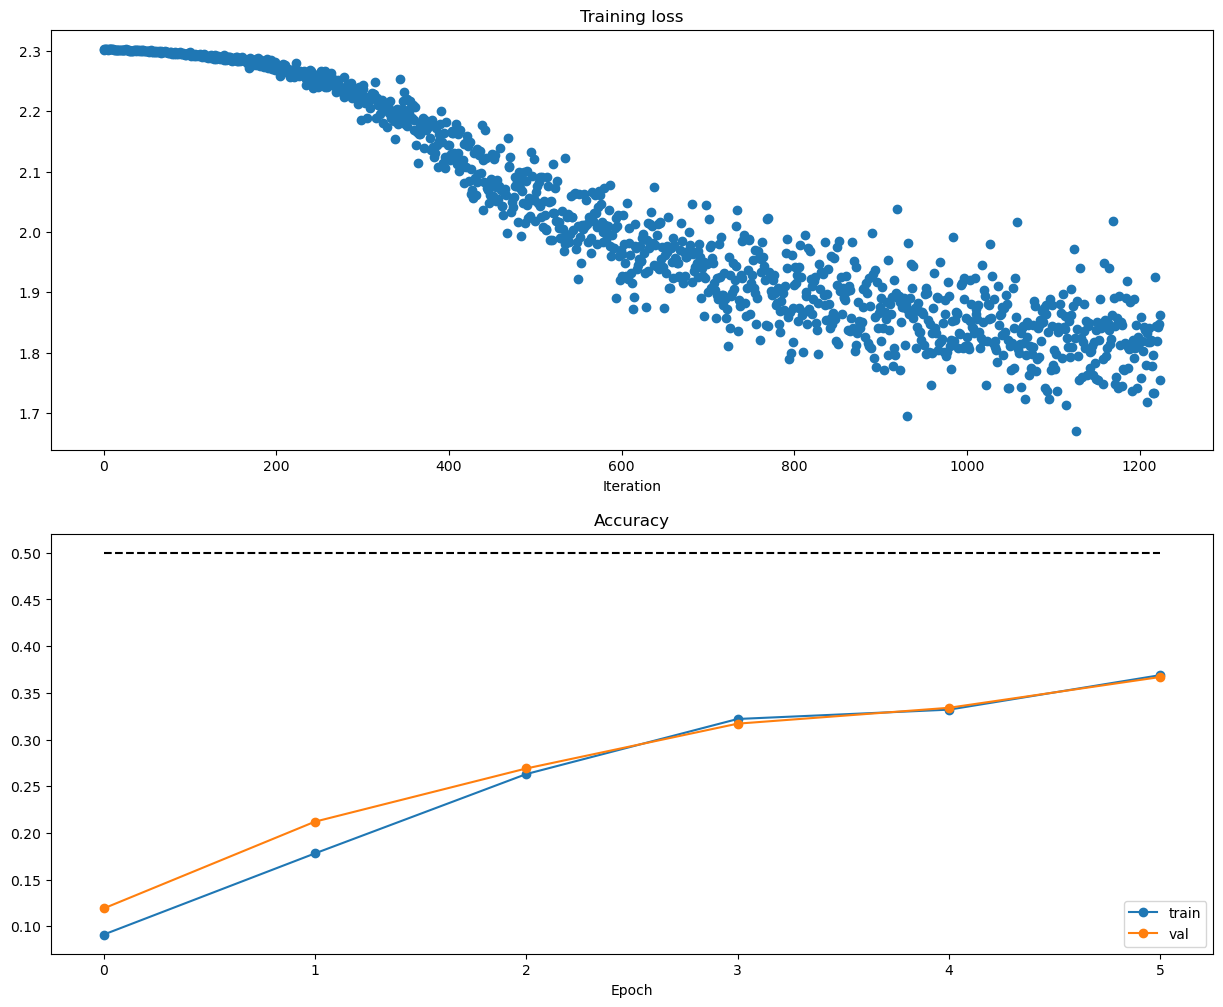

In [13]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

In [3]:
from cs231n.vis_utils import visualize_grid

# Visualize the weights of the network

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(3, 32, 32, -1).transpose(3, 1, 2, 0)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(model)


NameError: name 'plt' is not defined

# Tune your hyperparameters

**What's wrong?**.从上面的可视化来看，我们看到损失或多或少呈线性下降，这似乎表明学习率可能太低此外，训练和验证准确性之间没有差距，这表明我们使用的模型容量较低，我们应该增加其规模另一方面，对于一个非常大的模型，我们预计会看到更多的过拟合，这将表现为训练和验证准确性之间的巨大差距

**Tuning**. 调整超参数并发展它们如何影响最终性能的直觉是使用神经网络的重要组成部分，因此我们希望您进行大量练习。下面，您应该对各种超参数的不同值进行实验，包括隐藏层大小、学习率、训练时期的数量和正则化强度。您也可以考虑调整学习率衰减，但应该能够使用默认值获得良好的性能。

**Approximate results**. 您的目标应该是在验证集上实现大于48%的分类准确率。我们最好的网络在验证集上获得了超过52%的支持。
**Experiment**: 本练习的目标是通过完全连接的神经网络，在CIFAR-10上取得尽可能好的结果（52%可以作为参考）。随意实现您自己的技术（例如，PCA以降低维度，或添加丢弃，或向解算器添加功能，等等）

(Iteration 1 / 1225) loss: 2.300751
(Epoch 0 / 5) train acc: 0.135000; val_acc: 0.136000
(Iteration 101 / 1225) loss: 1.847421
(Iteration 201 / 1225) loss: 1.785894
(Epoch 1 / 5) train acc: 0.414000; val_acc: 0.424000
(Iteration 301 / 1225) loss: 1.600999
(Iteration 401 / 1225) loss: 1.609400
(Epoch 2 / 5) train acc: 0.469000; val_acc: 0.456000
(Iteration 501 / 1225) loss: 1.427779
(Iteration 601 / 1225) loss: 1.523345
(Iteration 701 / 1225) loss: 1.502628
(Epoch 3 / 5) train acc: 0.444000; val_acc: 0.450000
(Iteration 801 / 1225) loss: 1.480428
(Iteration 901 / 1225) loss: 1.431376
(Epoch 4 / 5) train acc: 0.453000; val_acc: 0.452000
(Iteration 1001 / 1225) loss: 1.441485
(Iteration 1101 / 1225) loss: 1.344889
(Iteration 1201 / 1225) loss: 1.498969
(Epoch 5 / 5) train acc: 0.512000; val_acc: 0.474000
batch_size = 200, lr = 0.001000, hidden size = 50.000000, Valid_accuracy: 0.474000


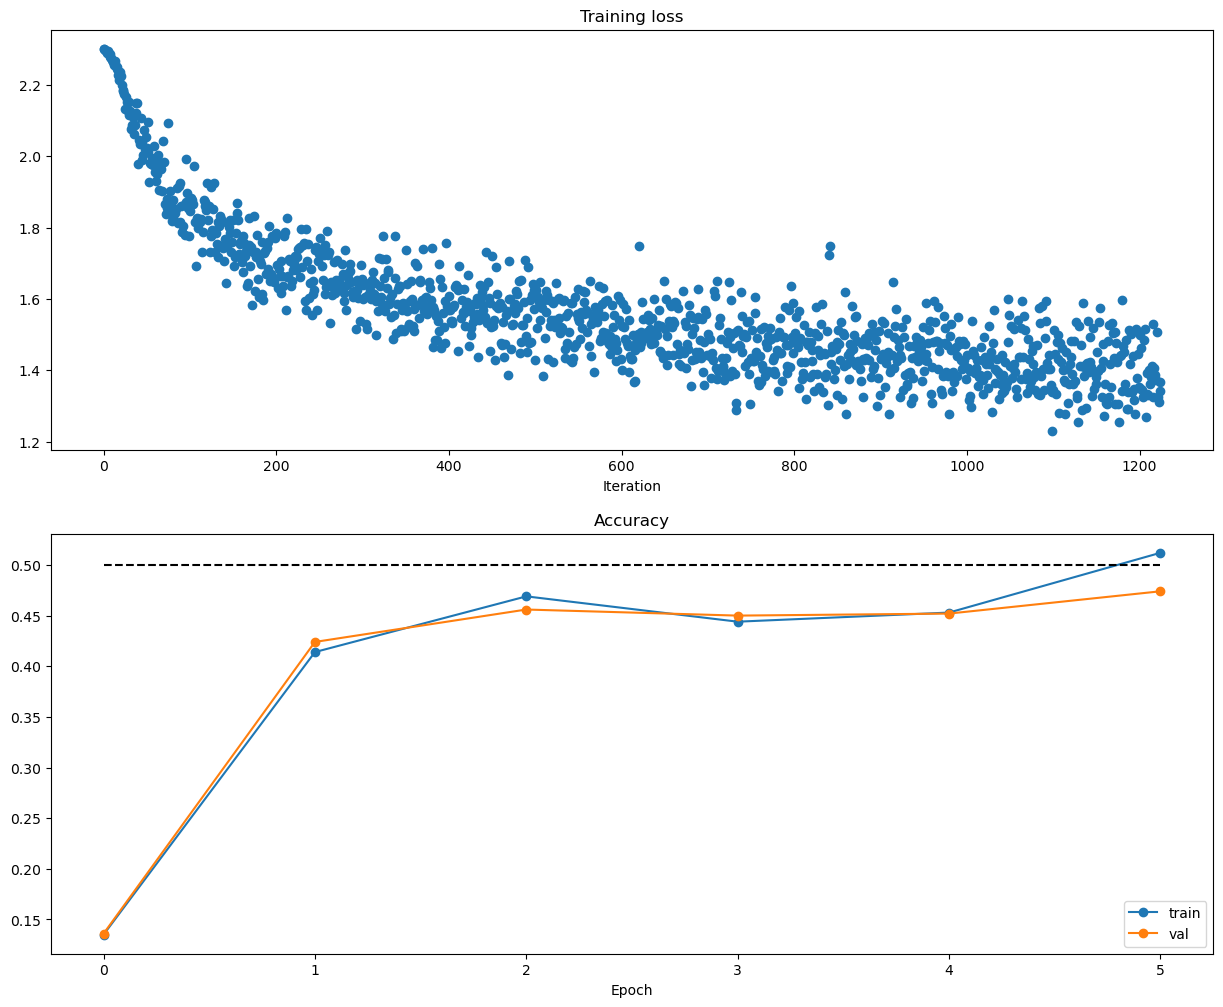

(Iteration 1 / 1225) loss: 2.303336
(Epoch 0 / 5) train acc: 0.096000; val_acc: 0.113000
(Iteration 101 / 1225) loss: 1.774341
(Iteration 201 / 1225) loss: 1.677945
(Epoch 1 / 5) train acc: 0.454000; val_acc: 0.409000
(Iteration 301 / 1225) loss: 1.641805
(Iteration 401 / 1225) loss: 1.514611
(Epoch 2 / 5) train acc: 0.464000; val_acc: 0.471000
(Iteration 501 / 1225) loss: 1.507893
(Iteration 601 / 1225) loss: 1.551128
(Iteration 701 / 1225) loss: 1.386320
(Epoch 3 / 5) train acc: 0.516000; val_acc: 0.460000
(Iteration 801 / 1225) loss: 1.380133
(Iteration 901 / 1225) loss: 1.377876
(Epoch 4 / 5) train acc: 0.496000; val_acc: 0.499000
(Iteration 1001 / 1225) loss: 1.347333
(Iteration 1101 / 1225) loss: 1.405141
(Iteration 1201 / 1225) loss: 1.384243
(Epoch 5 / 5) train acc: 0.536000; val_acc: 0.501000
batch_size = 200, lr = 0.001000, hidden size = 100.000000, Valid_accuracy: 0.501000


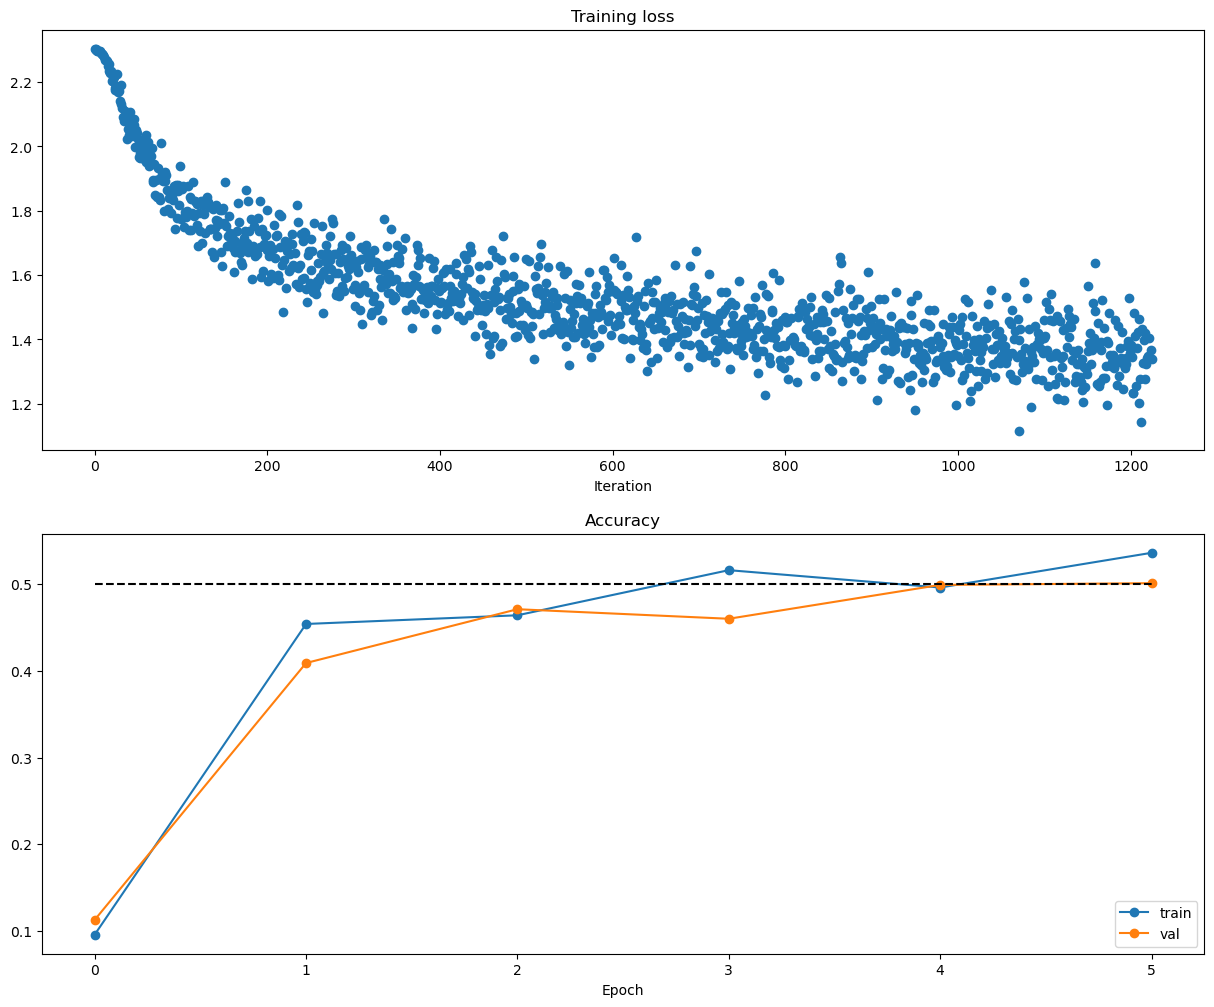

(Iteration 1 / 1225) loss: 2.304385
(Epoch 0 / 5) train acc: 0.139000; val_acc: 0.162000
(Iteration 101 / 1225) loss: 1.856000
(Iteration 201 / 1225) loss: 1.692040
(Epoch 1 / 5) train acc: 0.417000; val_acc: 0.438000
(Iteration 301 / 1225) loss: 1.536788
(Iteration 401 / 1225) loss: 1.680632
(Epoch 2 / 5) train acc: 0.460000; val_acc: 0.461000
(Iteration 501 / 1225) loss: 1.451994
(Iteration 601 / 1225) loss: 1.488502
(Iteration 701 / 1225) loss: 1.302656
(Epoch 3 / 5) train acc: 0.496000; val_acc: 0.478000
(Iteration 801 / 1225) loss: 1.398463
(Iteration 901 / 1225) loss: 1.321227
(Epoch 4 / 5) train acc: 0.521000; val_acc: 0.491000
(Iteration 1001 / 1225) loss: 1.427145
(Iteration 1101 / 1225) loss: 1.345013
(Iteration 1201 / 1225) loss: 1.418822
(Epoch 5 / 5) train acc: 0.526000; val_acc: 0.507000
batch_size = 200, lr = 0.001000, hidden size = 200.000000, Valid_accuracy: 0.507000


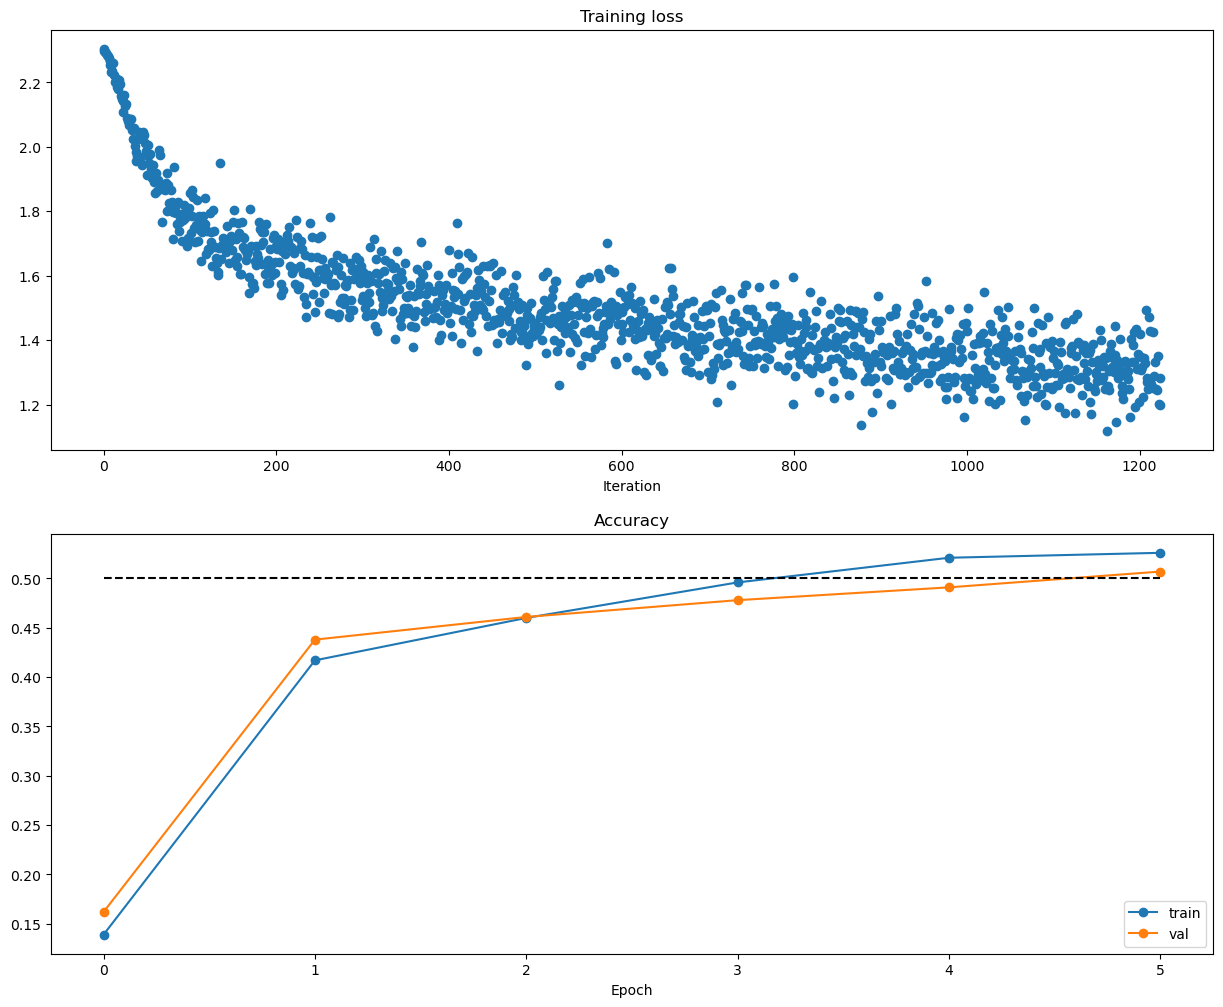

(Iteration 1 / 1225) loss: 2.303647
(Epoch 0 / 5) train acc: 0.112000; val_acc: 0.083000
(Iteration 101 / 1225) loss: 2.295190
(Iteration 201 / 1225) loss: 2.267949
(Epoch 1 / 5) train acc: 0.186000; val_acc: 0.231000
(Iteration 301 / 1225) loss: 2.178116
(Iteration 401 / 1225) loss: 2.124966
(Epoch 2 / 5) train acc: 0.252000; val_acc: 0.271000
(Iteration 501 / 1225) loss: 1.971628
(Iteration 601 / 1225) loss: 1.983007
(Iteration 701 / 1225) loss: 1.972981
(Epoch 3 / 5) train acc: 0.275000; val_acc: 0.309000
(Iteration 801 / 1225) loss: 1.933405
(Iteration 901 / 1225) loss: 1.944092
(Epoch 4 / 5) train acc: 0.341000; val_acc: 0.337000
(Iteration 1001 / 1225) loss: 1.842554
(Iteration 1101 / 1225) loss: 1.827467
(Iteration 1201 / 1225) loss: 1.812975
(Epoch 5 / 5) train acc: 0.366000; val_acc: 0.344000
batch_size = 200, lr = 0.000100, hidden size = 50.000000, Valid_accuracy: 0.344000


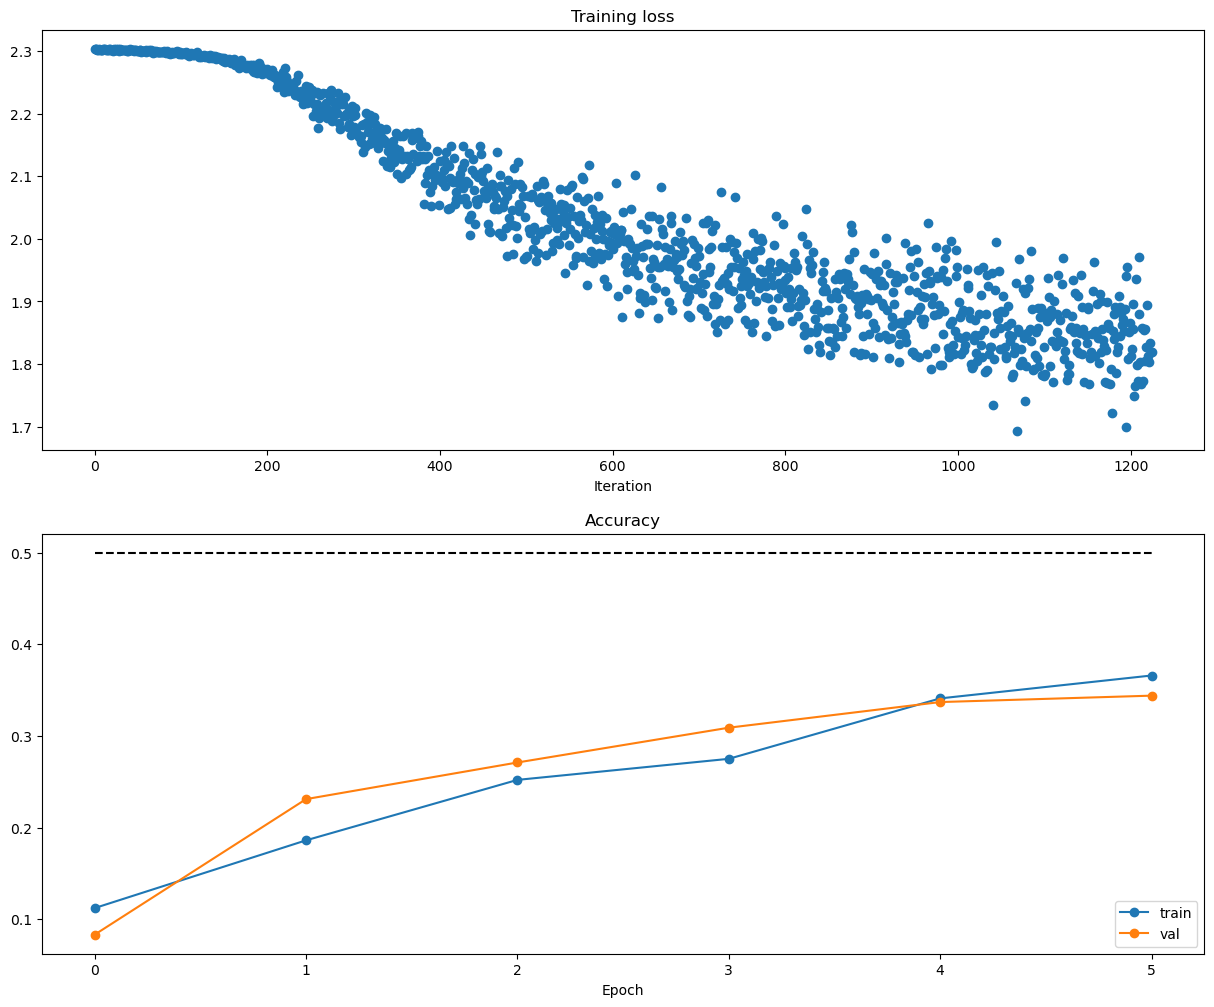

(Iteration 1 / 1225) loss: 2.303582
(Epoch 0 / 5) train acc: 0.118000; val_acc: 0.097000
(Iteration 101 / 1225) loss: 2.268196
(Iteration 201 / 1225) loss: 2.185140
(Epoch 1 / 5) train acc: 0.253000; val_acc: 0.266000
(Iteration 301 / 1225) loss: 2.145129
(Iteration 401 / 1225) loss: 2.005556
(Epoch 2 / 5) train acc: 0.319000; val_acc: 0.306000
(Iteration 501 / 1225) loss: 1.981140
(Iteration 601 / 1225) loss: 1.949906
(Iteration 701 / 1225) loss: 1.850942
(Epoch 3 / 5) train acc: 0.332000; val_acc: 0.341000
(Iteration 801 / 1225) loss: 1.884675
(Iteration 901 / 1225) loss: 1.890995
(Epoch 4 / 5) train acc: 0.376000; val_acc: 0.363000
(Iteration 1001 / 1225) loss: 1.819067
(Iteration 1101 / 1225) loss: 1.823403
(Iteration 1201 / 1225) loss: 1.786800
(Epoch 5 / 5) train acc: 0.393000; val_acc: 0.373000
batch_size = 200, lr = 0.000100, hidden size = 100.000000, Valid_accuracy: 0.373000


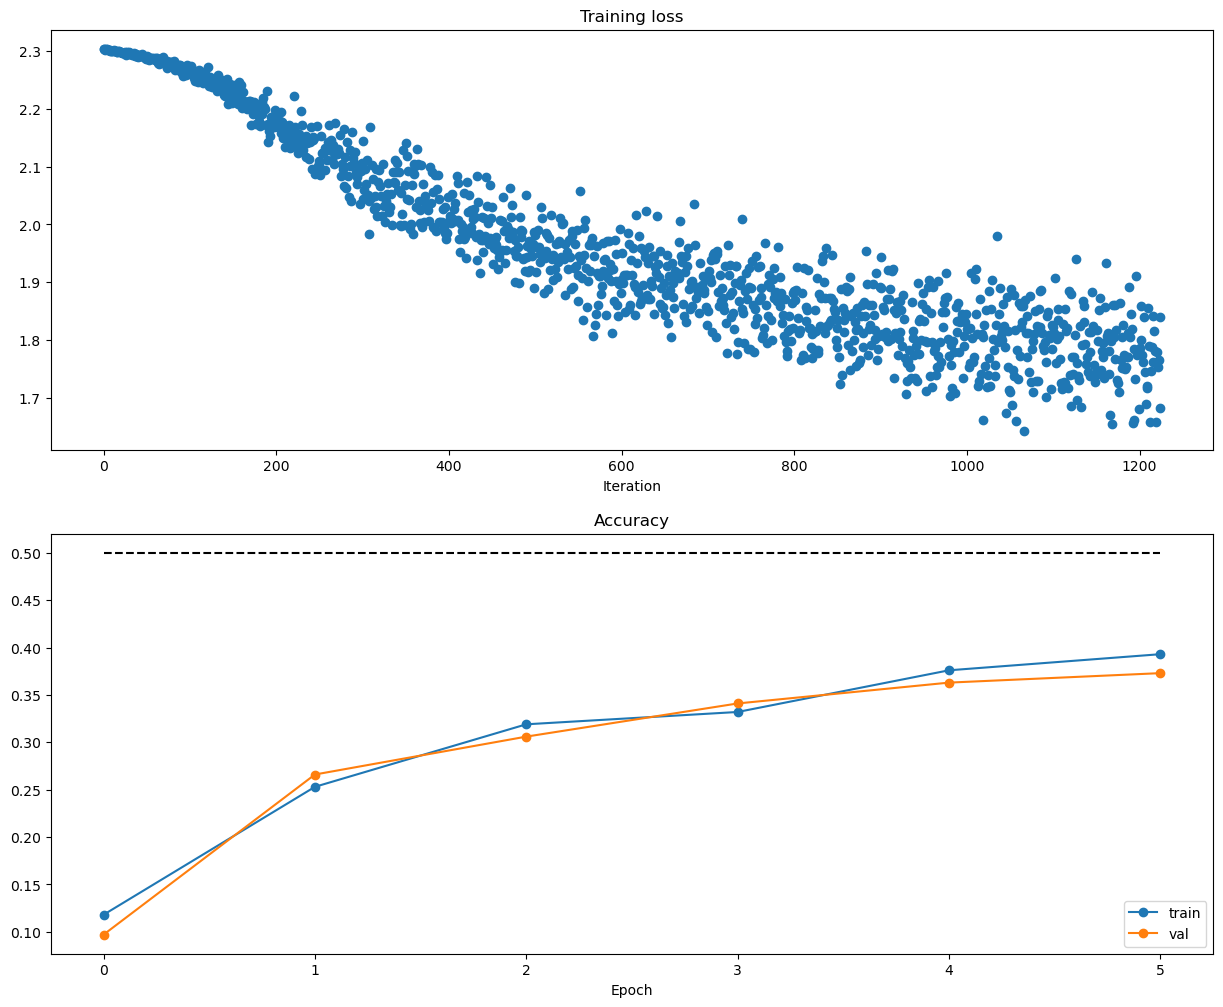

(Iteration 1 / 1225) loss: 2.299227
(Epoch 0 / 5) train acc: 0.129000; val_acc: 0.120000
(Iteration 101 / 1225) loss: 2.242595
(Iteration 201 / 1225) loss: 2.160829
(Epoch 1 / 5) train acc: 0.307000; val_acc: 0.277000
(Iteration 301 / 1225) loss: 2.072074
(Iteration 401 / 1225) loss: 2.040328
(Epoch 2 / 5) train acc: 0.316000; val_acc: 0.312000
(Iteration 501 / 1225) loss: 1.956334
(Iteration 601 / 1225) loss: 1.952928
(Iteration 701 / 1225) loss: 1.864813
(Epoch 3 / 5) train acc: 0.352000; val_acc: 0.349000
(Iteration 801 / 1225) loss: 1.802460
(Iteration 901 / 1225) loss: 1.782199
(Epoch 4 / 5) train acc: 0.385000; val_acc: 0.379000
(Iteration 1001 / 1225) loss: 1.908454
(Iteration 1101 / 1225) loss: 1.753039
(Iteration 1201 / 1225) loss: 1.705493
(Epoch 5 / 5) train acc: 0.384000; val_acc: 0.384000
batch_size = 200, lr = 0.000100, hidden size = 200.000000, Valid_accuracy: 0.384000


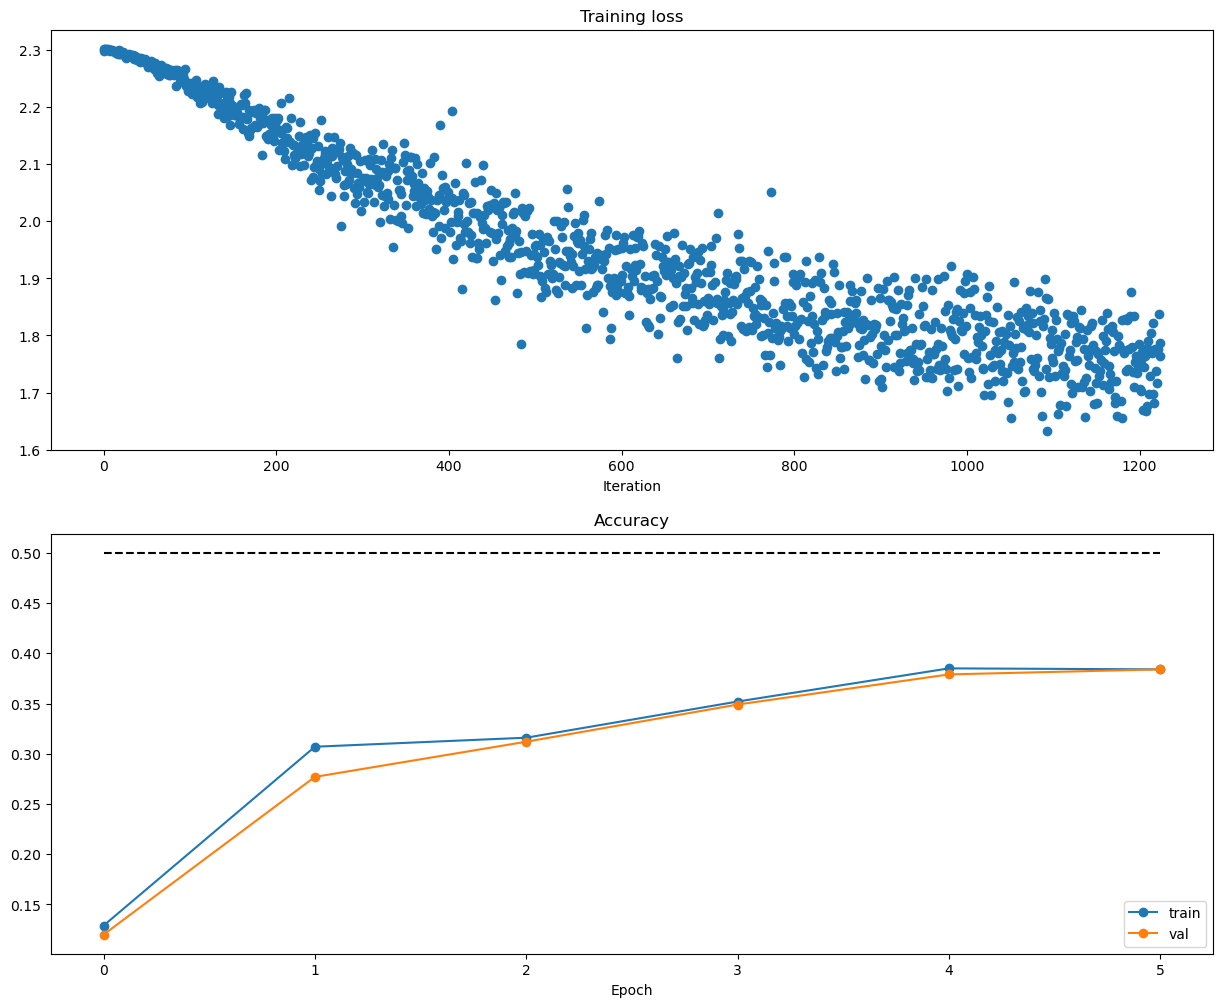

(Iteration 1 / 1225) loss: 2.301332
(Epoch 0 / 5) train acc: 0.127000; val_acc: 0.107000
(Iteration 101 / 1225) loss: 2.300210
(Iteration 201 / 1225) loss: 2.298817
(Epoch 1 / 5) train acc: 0.184000; val_acc: 0.188000
(Iteration 301 / 1225) loss: 2.297692
(Iteration 401 / 1225) loss: 2.295817
(Epoch 2 / 5) train acc: 0.206000; val_acc: 0.214000
(Iteration 501 / 1225) loss: 2.291145
(Iteration 601 / 1225) loss: 2.293791
(Iteration 701 / 1225) loss: 2.287328
(Epoch 3 / 5) train acc: 0.216000; val_acc: 0.222000
(Iteration 801 / 1225) loss: 2.284768
(Iteration 901 / 1225) loss: 2.282929
(Epoch 4 / 5) train acc: 0.225000; val_acc: 0.224000
(Iteration 1001 / 1225) loss: 2.277345
(Iteration 1101 / 1225) loss: 2.277402
(Iteration 1201 / 1225) loss: 2.272534
(Epoch 5 / 5) train acc: 0.194000; val_acc: 0.223000
batch_size = 200, lr = 0.000010, hidden size = 50.000000, Valid_accuracy: 0.224000


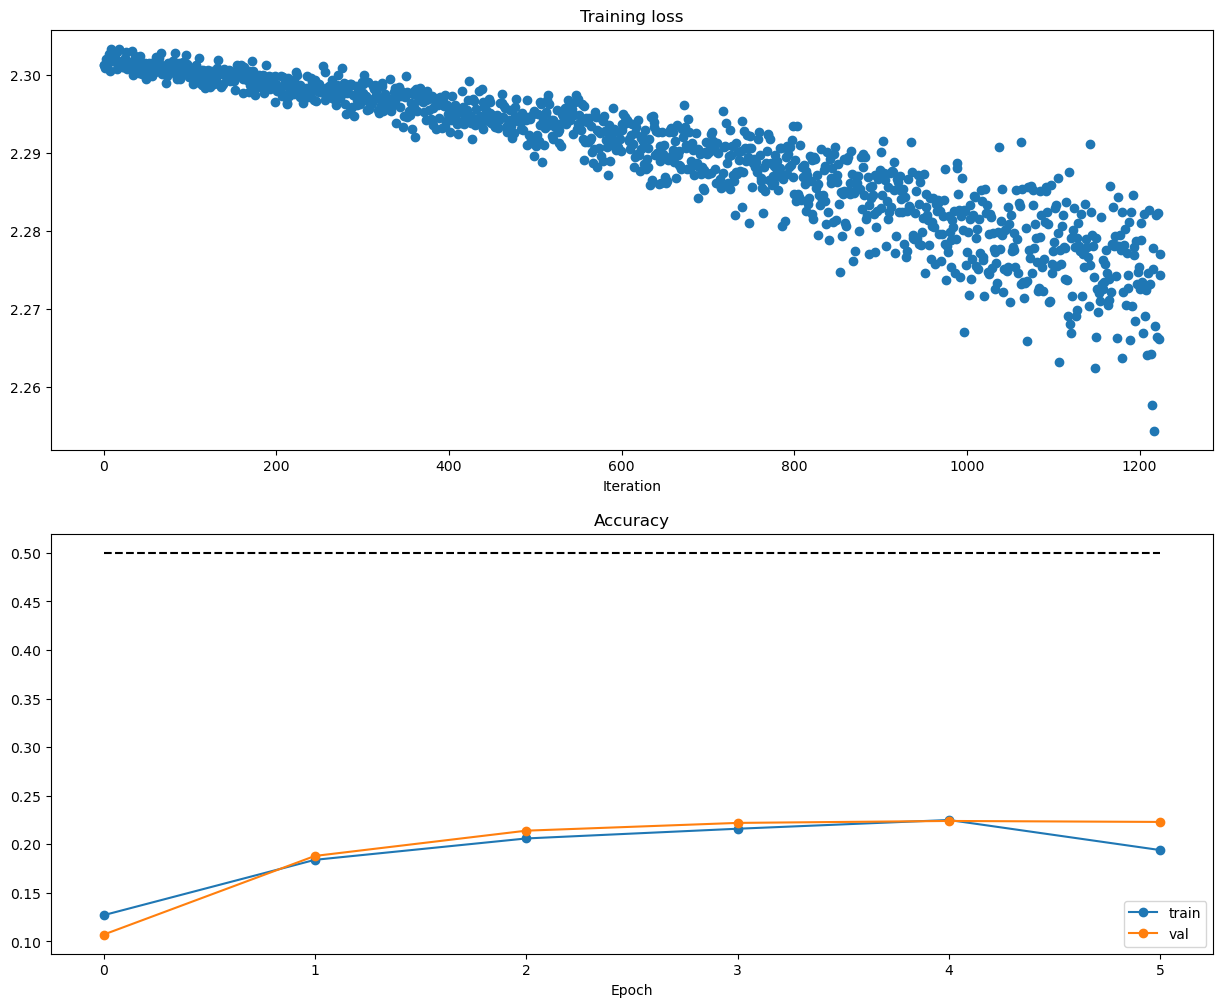

(Iteration 1 / 1225) loss: 2.301275
(Epoch 0 / 5) train acc: 0.107000; val_acc: 0.124000
(Iteration 101 / 1225) loss: 2.299766
(Iteration 201 / 1225) loss: 2.298005
(Epoch 1 / 5) train acc: 0.192000; val_acc: 0.212000
(Iteration 301 / 1225) loss: 2.294369
(Iteration 401 / 1225) loss: 2.288576
(Epoch 2 / 5) train acc: 0.194000; val_acc: 0.213000
(Iteration 501 / 1225) loss: 2.287383
(Iteration 601 / 1225) loss: 2.280061
(Iteration 701 / 1225) loss: 2.278441
(Epoch 3 / 5) train acc: 0.179000; val_acc: 0.220000
(Iteration 801 / 1225) loss: 2.268436
(Iteration 901 / 1225) loss: 2.271858
(Epoch 4 / 5) train acc: 0.208000; val_acc: 0.211000
(Iteration 1001 / 1225) loss: 2.286469
(Iteration 1101 / 1225) loss: 2.276768
(Iteration 1201 / 1225) loss: 2.227551
(Epoch 5 / 5) train acc: 0.223000; val_acc: 0.207000
batch_size = 200, lr = 0.000010, hidden size = 100.000000, Valid_accuracy: 0.220000


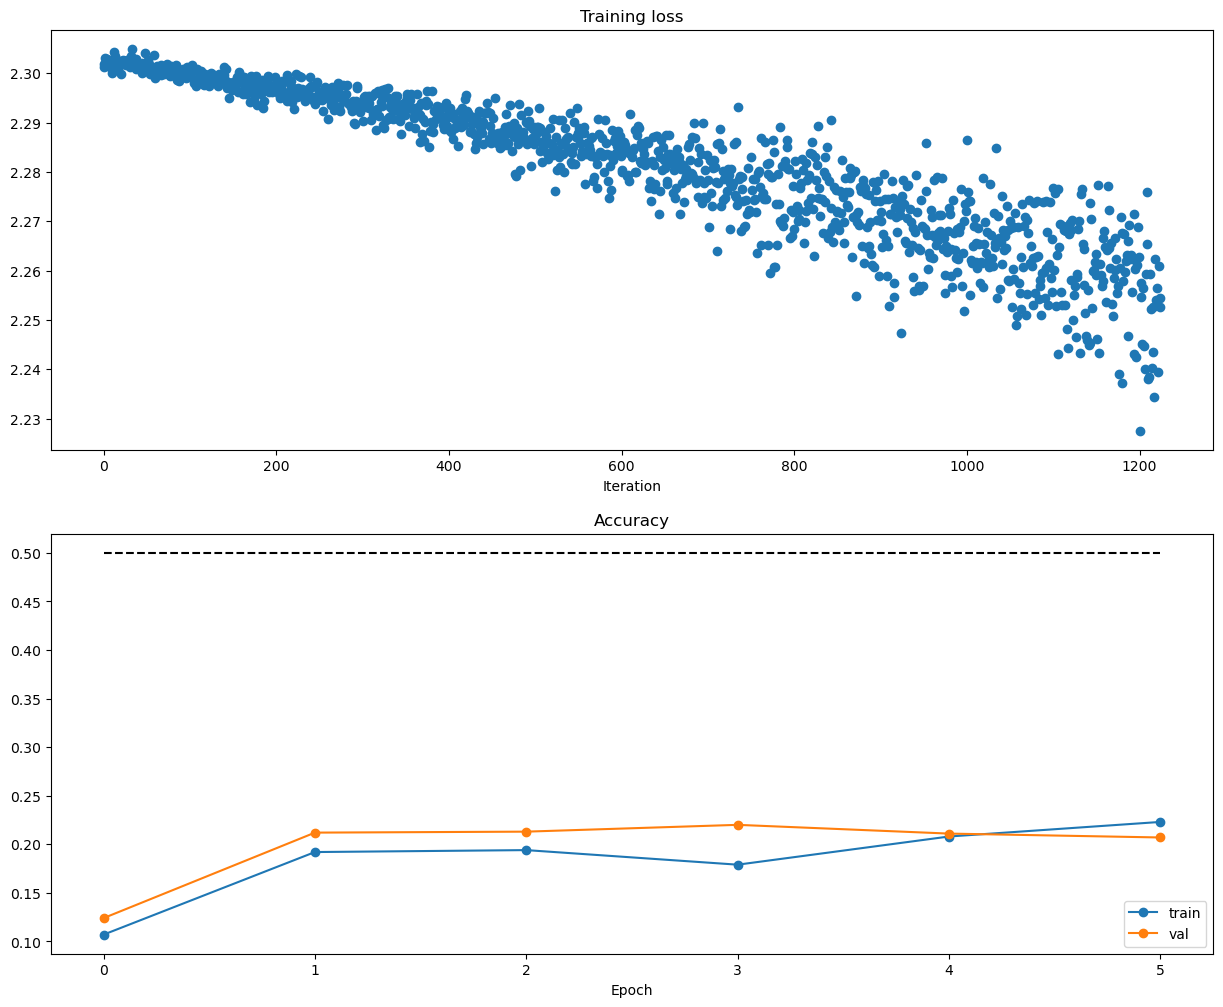

(Iteration 1 / 1225) loss: 2.300073
(Epoch 0 / 5) train acc: 0.125000; val_acc: 0.149000
(Iteration 101 / 1225) loss: 2.297812
(Iteration 201 / 1225) loss: 2.293121
(Epoch 1 / 5) train acc: 0.192000; val_acc: 0.212000
(Iteration 301 / 1225) loss: 2.288423
(Iteration 401 / 1225) loss: 2.277772
(Epoch 2 / 5) train acc: 0.232000; val_acc: 0.234000
(Iteration 501 / 1225) loss: 2.279191
(Iteration 601 / 1225) loss: 2.279746
(Iteration 701 / 1225) loss: 2.267016
(Epoch 3 / 5) train acc: 0.241000; val_acc: 0.256000
(Iteration 801 / 1225) loss: 2.259967
(Iteration 901 / 1225) loss: 2.273014
(Epoch 4 / 5) train acc: 0.231000; val_acc: 0.262000
(Iteration 1001 / 1225) loss: 2.248437
(Iteration 1101 / 1225) loss: 2.251843
(Iteration 1201 / 1225) loss: 2.231426
(Epoch 5 / 5) train acc: 0.260000; val_acc: 0.266000
batch_size = 200, lr = 0.000010, hidden size = 200.000000, Valid_accuracy: 0.266000


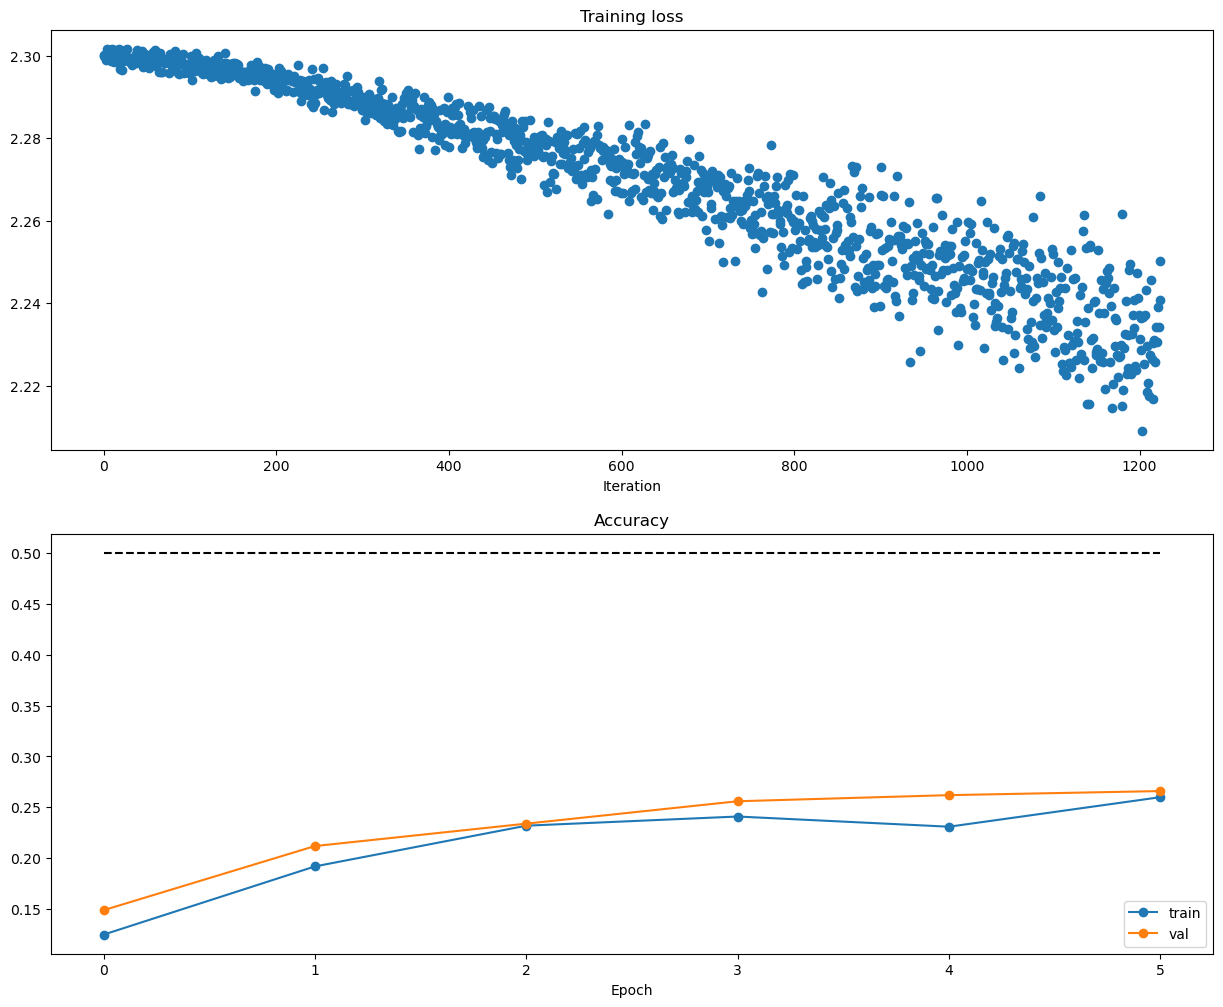

(Iteration 1 / 610) loss: 2.303049
(Epoch 0 / 5) train acc: 0.134000; val_acc: 0.126000
(Iteration 101 / 610) loss: 1.809977
(Epoch 1 / 5) train acc: 0.334000; val_acc: 0.354000
(Iteration 201 / 610) loss: 1.697578
(Epoch 2 / 5) train acc: 0.420000; val_acc: 0.413000
(Iteration 301 / 610) loss: 1.624486
(Epoch 3 / 5) train acc: 0.426000; val_acc: 0.450000
(Iteration 401 / 610) loss: 1.531205
(Epoch 4 / 5) train acc: 0.443000; val_acc: 0.446000
(Iteration 501 / 610) loss: 1.632434
(Iteration 601 / 610) loss: 1.454893
(Epoch 5 / 5) train acc: 0.505000; val_acc: 0.469000
batch_size = 400, lr = 0.001000, hidden size = 50.000000, Valid_accuracy: 0.469000


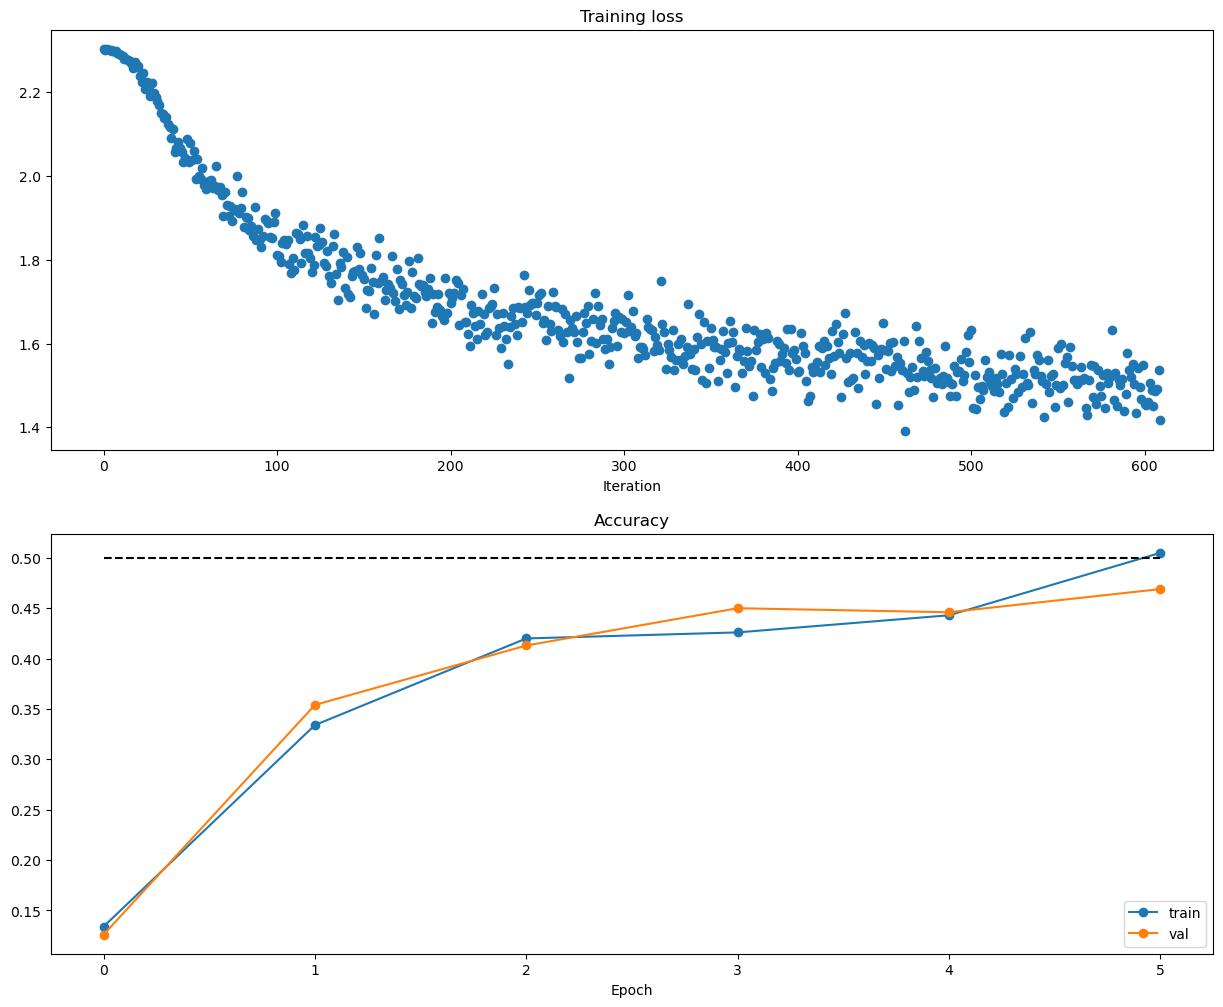

(Iteration 1 / 610) loss: 2.301457
(Epoch 0 / 5) train acc: 0.126000; val_acc: 0.150000
(Iteration 101 / 610) loss: 1.756946
(Epoch 1 / 5) train acc: 0.397000; val_acc: 0.386000
(Iteration 201 / 610) loss: 1.664649
(Epoch 2 / 5) train acc: 0.442000; val_acc: 0.453000
(Iteration 301 / 610) loss: 1.568276
(Epoch 3 / 5) train acc: 0.453000; val_acc: 0.470000
(Iteration 401 / 610) loss: 1.468810
(Epoch 4 / 5) train acc: 0.492000; val_acc: 0.467000
(Iteration 501 / 610) loss: 1.457344
(Iteration 601 / 610) loss: 1.446582
(Epoch 5 / 5) train acc: 0.472000; val_acc: 0.482000
batch_size = 400, lr = 0.001000, hidden size = 100.000000, Valid_accuracy: 0.482000


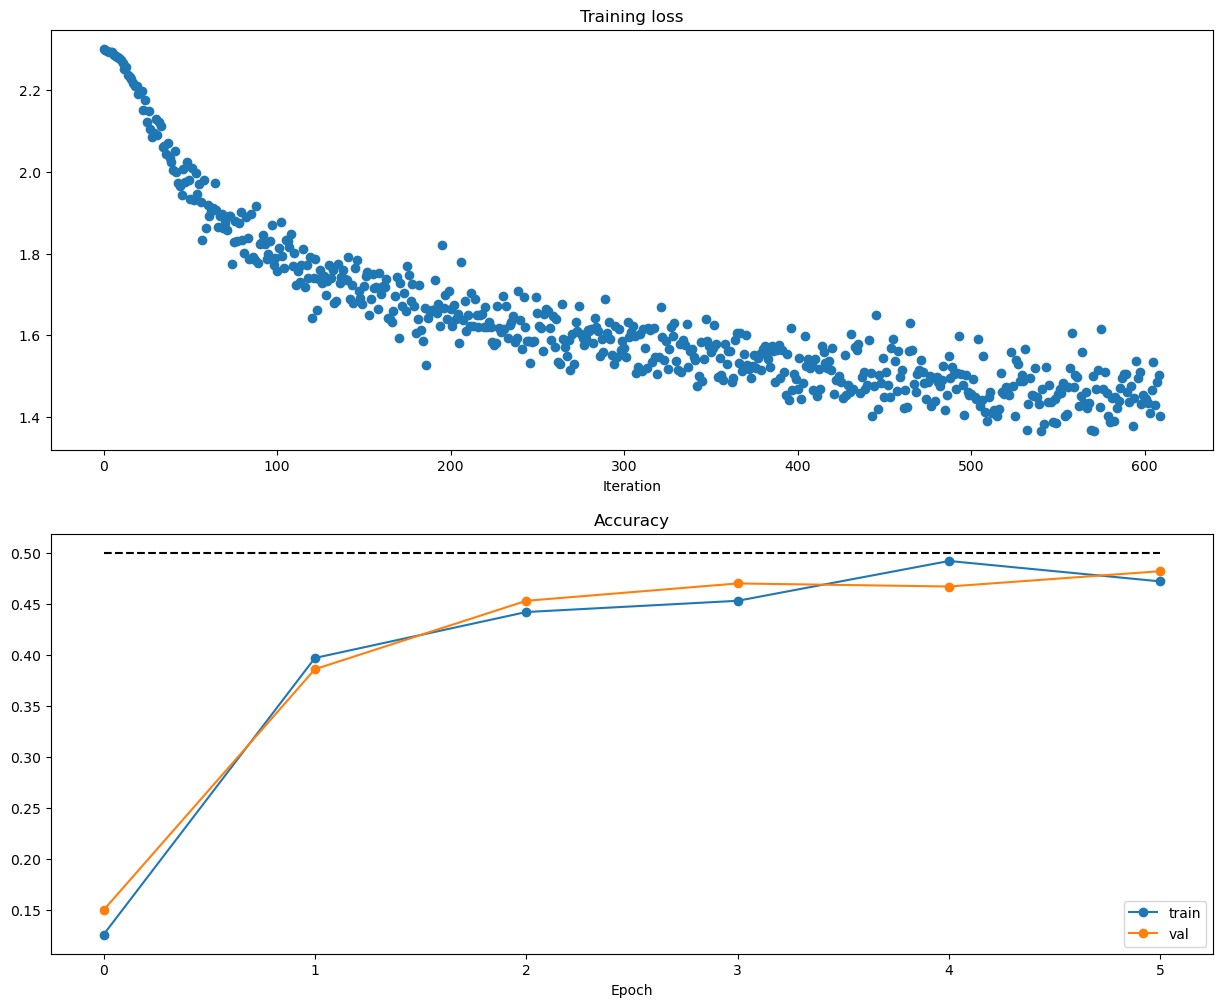

(Iteration 1 / 610) loss: 2.302539
(Epoch 0 / 5) train acc: 0.142000; val_acc: 0.127000
(Iteration 101 / 610) loss: 1.799381
(Epoch 1 / 5) train acc: 0.394000; val_acc: 0.398000
(Iteration 201 / 610) loss: 1.651214
(Epoch 2 / 5) train acc: 0.475000; val_acc: 0.429000
(Iteration 301 / 610) loss: 1.575329
(Epoch 3 / 5) train acc: 0.470000; val_acc: 0.463000
(Iteration 401 / 610) loss: 1.545791
(Epoch 4 / 5) train acc: 0.497000; val_acc: 0.466000
(Iteration 501 / 610) loss: 1.413478
(Iteration 601 / 610) loss: 1.486707
(Epoch 5 / 5) train acc: 0.486000; val_acc: 0.474000
batch_size = 400, lr = 0.001000, hidden size = 200.000000, Valid_accuracy: 0.474000


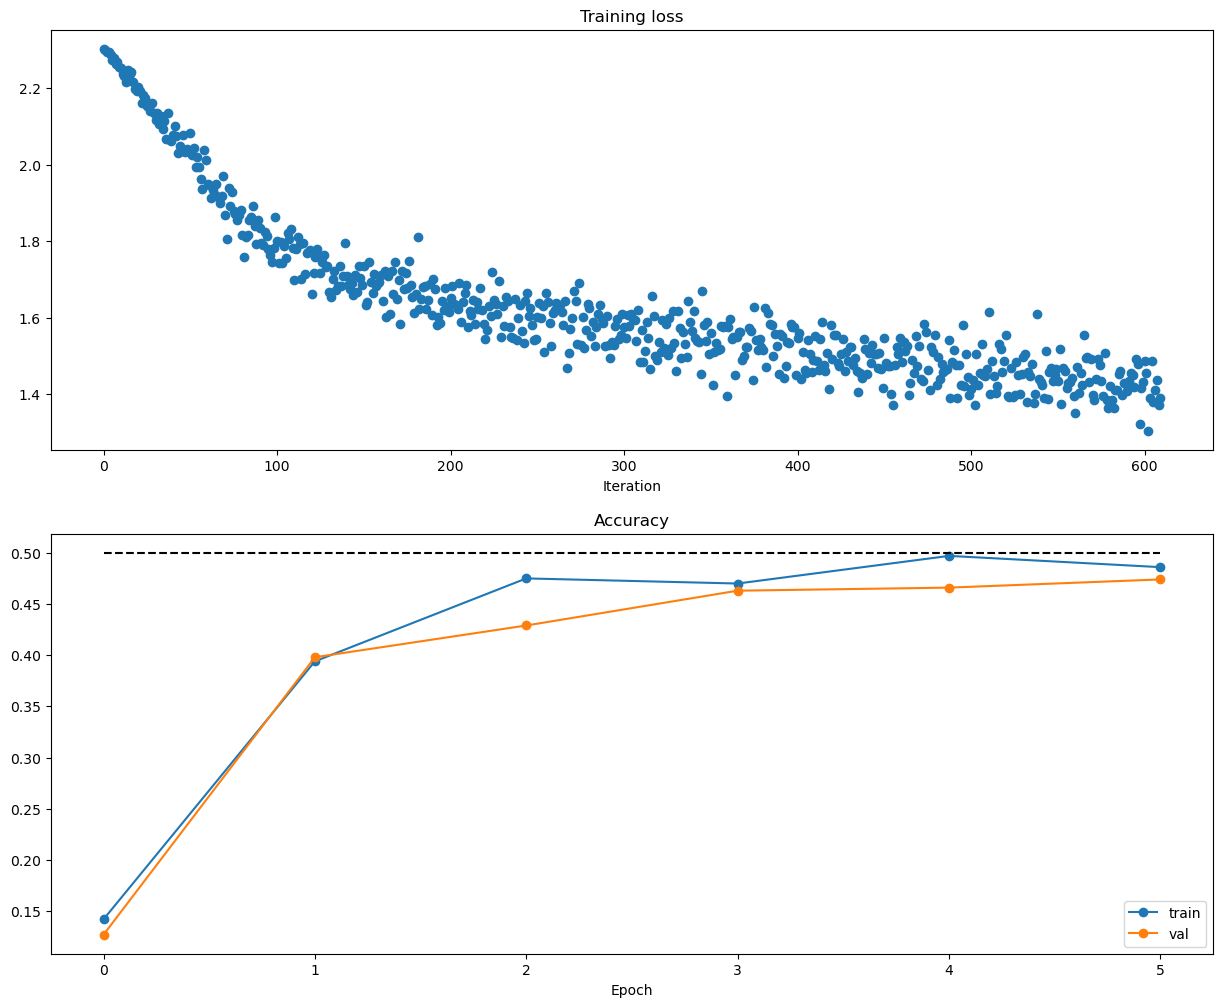

(Iteration 1 / 610) loss: 2.301782
(Epoch 0 / 5) train acc: 0.107000; val_acc: 0.085000
(Iteration 101 / 610) loss: 2.275144
(Epoch 1 / 5) train acc: 0.180000; val_acc: 0.187000
(Iteration 201 / 610) loss: 2.225344
(Epoch 2 / 5) train acc: 0.215000; val_acc: 0.235000
(Iteration 301 / 610) loss: 2.177935
(Epoch 3 / 5) train acc: 0.245000; val_acc: 0.242000
(Iteration 401 / 610) loss: 2.093159
(Epoch 4 / 5) train acc: 0.260000; val_acc: 0.259000
(Iteration 501 / 610) loss: 2.083584
(Iteration 601 / 610) loss: 2.058436
(Epoch 5 / 5) train acc: 0.304000; val_acc: 0.288000
batch_size = 400, lr = 0.000100, hidden size = 50.000000, Valid_accuracy: 0.288000


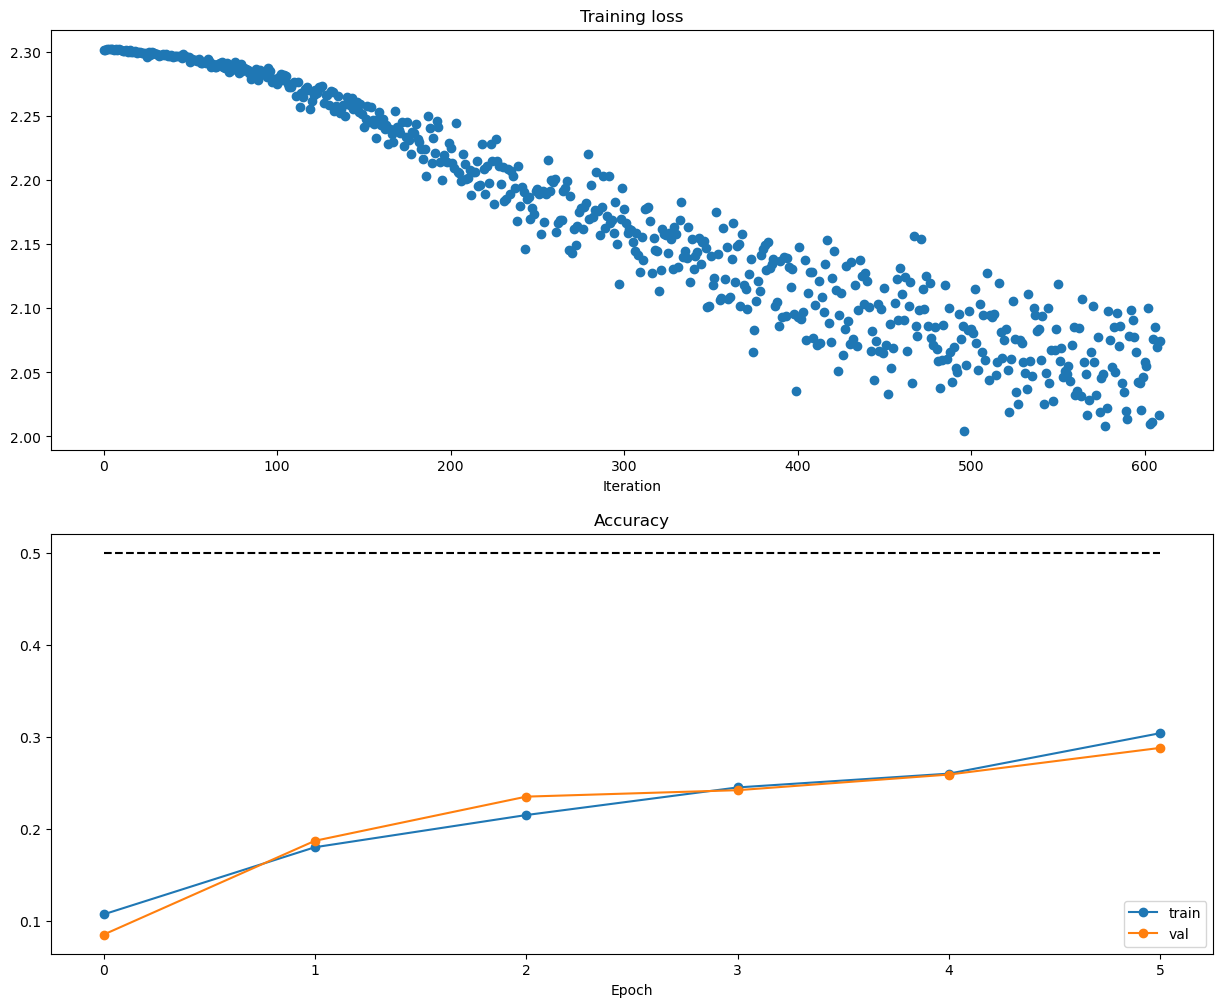

(Iteration 1 / 610) loss: 2.302975
(Epoch 0 / 5) train acc: 0.092000; val_acc: 0.104000
(Iteration 101 / 610) loss: 2.262763
(Epoch 1 / 5) train acc: 0.241000; val_acc: 0.227000
(Iteration 201 / 610) loss: 2.173664
(Epoch 2 / 5) train acc: 0.259000; val_acc: 0.255000
(Iteration 301 / 610) loss: 2.117358
(Epoch 3 / 5) train acc: 0.280000; val_acc: 0.277000
(Iteration 401 / 610) loss: 2.072018
(Epoch 4 / 5) train acc: 0.276000; val_acc: 0.300000
(Iteration 501 / 610) loss: 2.012555
(Iteration 601 / 610) loss: 2.016367
(Epoch 5 / 5) train acc: 0.315000; val_acc: 0.313000
batch_size = 400, lr = 0.000100, hidden size = 100.000000, Valid_accuracy: 0.313000


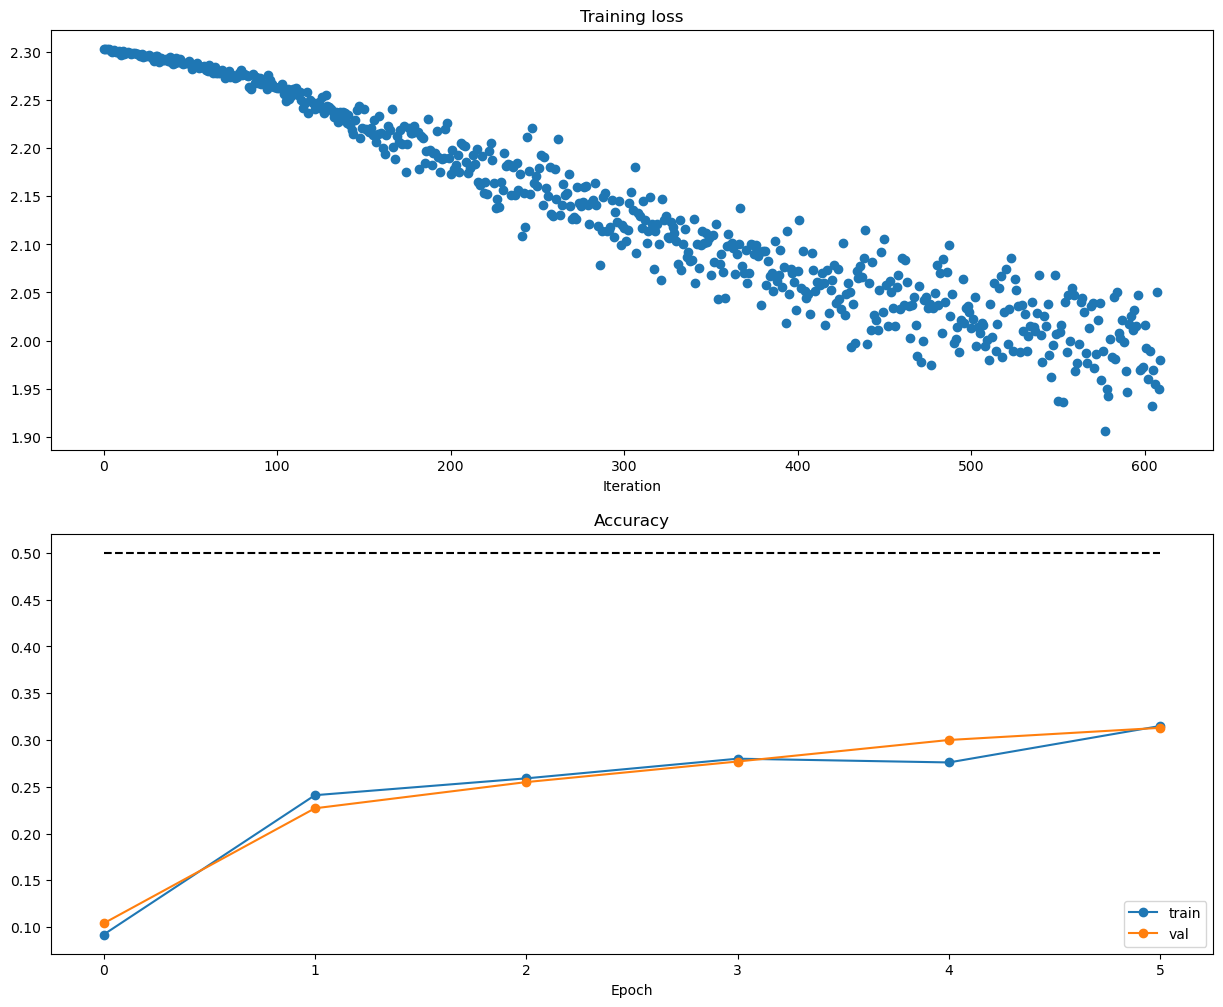

(Iteration 1 / 610) loss: 2.302417
(Epoch 0 / 5) train acc: 0.098000; val_acc: 0.101000
(Iteration 101 / 610) loss: 2.230465
(Epoch 1 / 5) train acc: 0.211000; val_acc: 0.233000
(Iteration 201 / 610) loss: 2.091018
(Epoch 2 / 5) train acc: 0.262000; val_acc: 0.284000
(Iteration 301 / 610) loss: 2.061366
(Epoch 3 / 5) train acc: 0.291000; val_acc: 0.309000
(Iteration 401 / 610) loss: 2.004617
(Epoch 4 / 5) train acc: 0.326000; val_acc: 0.321000
(Iteration 501 / 610) loss: 1.959292
(Iteration 601 / 610) loss: 1.924025
(Epoch 5 / 5) train acc: 0.329000; val_acc: 0.338000
batch_size = 400, lr = 0.000100, hidden size = 200.000000, Valid_accuracy: 0.338000


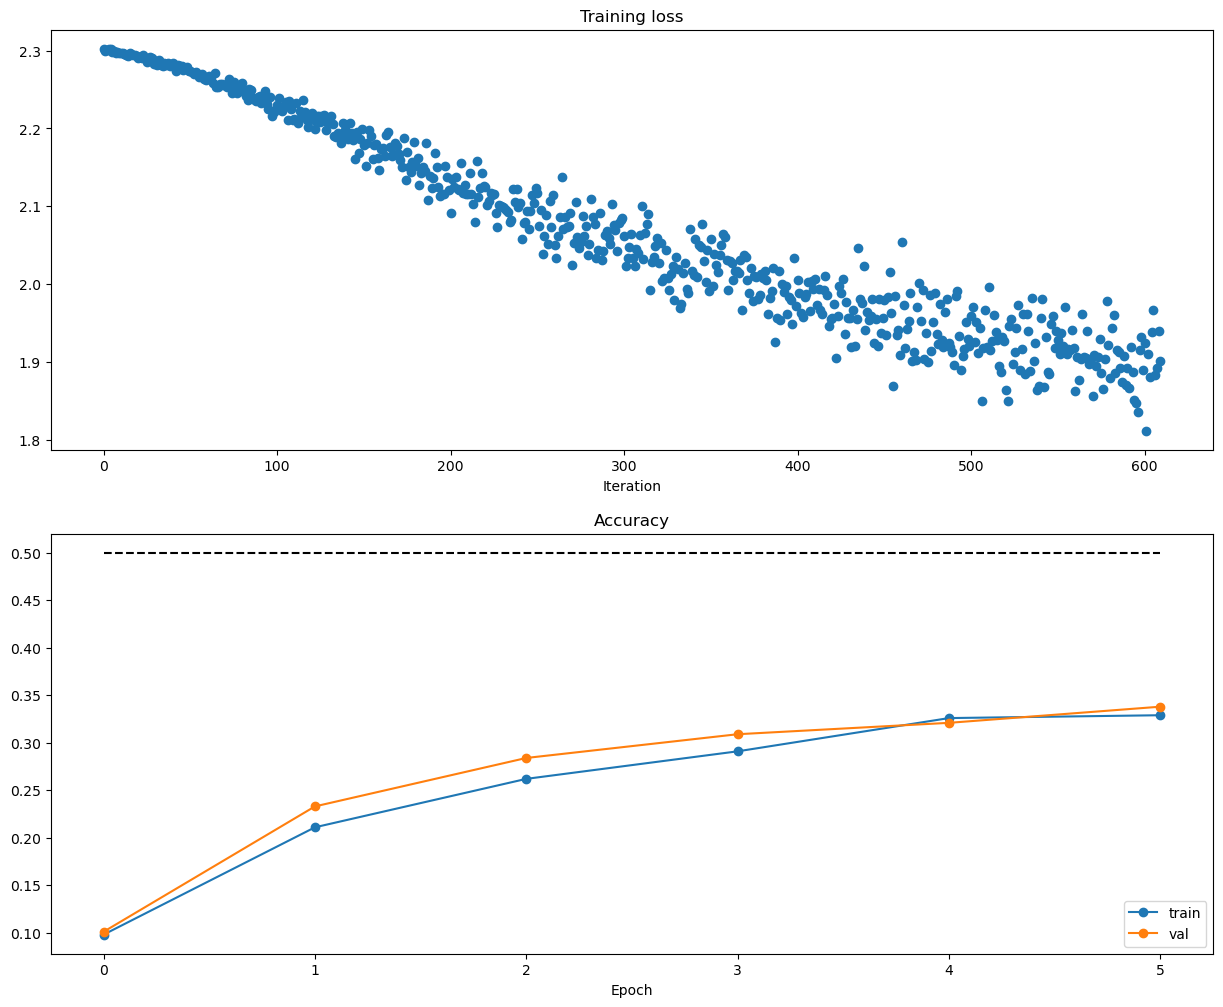

(Iteration 1 / 610) loss: 2.302227
(Epoch 0 / 5) train acc: 0.106000; val_acc: 0.107000
(Iteration 101 / 610) loss: 2.300399
(Epoch 1 / 5) train acc: 0.126000; val_acc: 0.136000
(Iteration 201 / 610) loss: 2.299824
(Epoch 2 / 5) train acc: 0.154000; val_acc: 0.159000
(Iteration 301 / 610) loss: 2.299261
(Epoch 3 / 5) train acc: 0.166000; val_acc: 0.181000
(Iteration 401 / 610) loss: 2.296418
(Epoch 4 / 5) train acc: 0.165000; val_acc: 0.186000
(Iteration 501 / 610) loss: 2.295692
(Iteration 601 / 610) loss: 2.292934
(Epoch 5 / 5) train acc: 0.187000; val_acc: 0.188000
batch_size = 400, lr = 0.000010, hidden size = 50.000000, Valid_accuracy: 0.188000


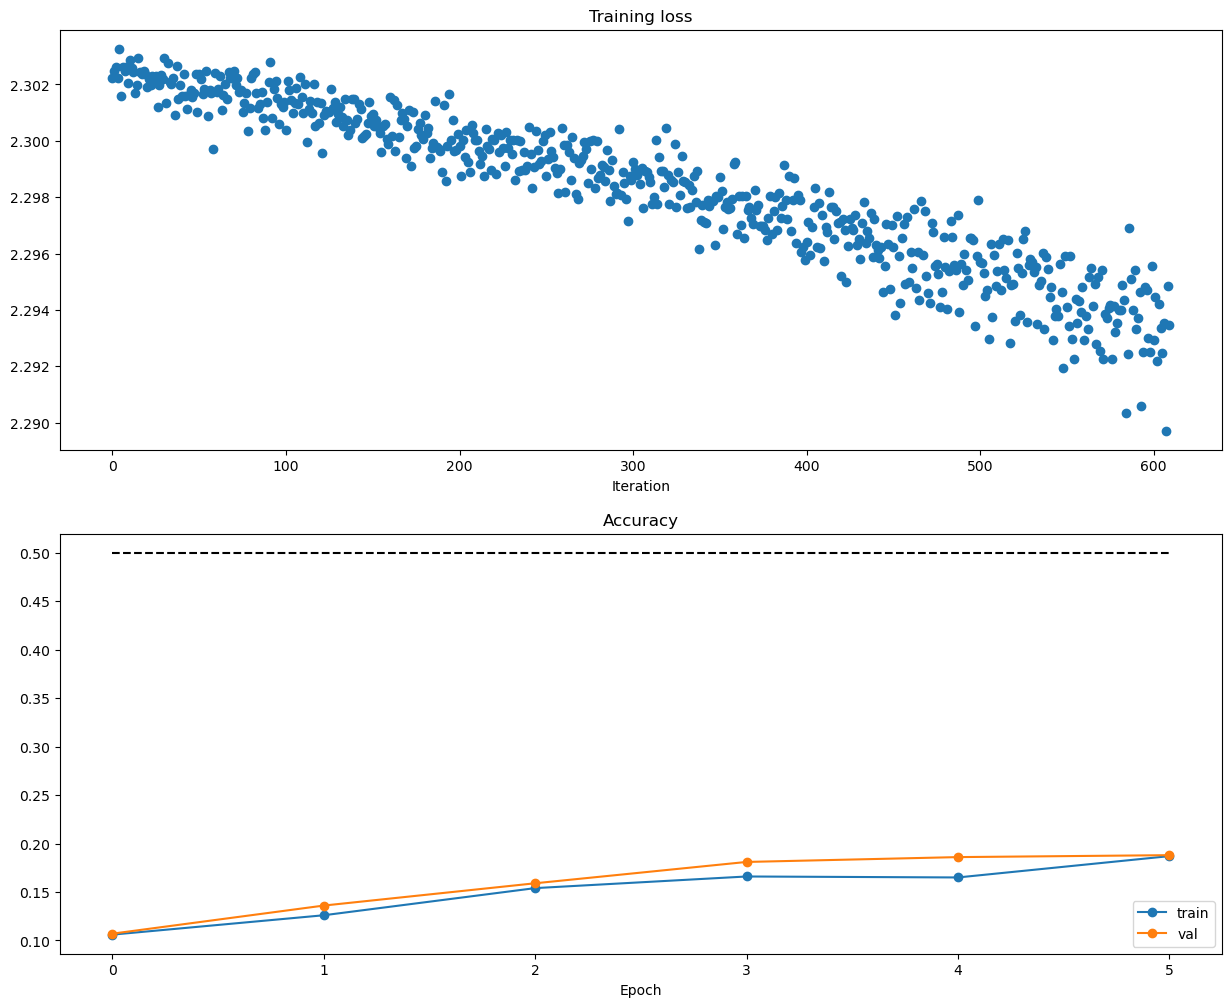

(Iteration 1 / 610) loss: 2.302824
(Epoch 0 / 5) train acc: 0.098000; val_acc: 0.090000
(Iteration 101 / 610) loss: 2.301659
(Epoch 1 / 5) train acc: 0.133000; val_acc: 0.134000
(Iteration 201 / 610) loss: 2.299512
(Epoch 2 / 5) train acc: 0.159000; val_acc: 0.184000
(Iteration 301 / 610) loss: 2.298216
(Epoch 3 / 5) train acc: 0.203000; val_acc: 0.197000
(Iteration 401 / 610) loss: 2.298134
(Epoch 4 / 5) train acc: 0.195000; val_acc: 0.201000
(Iteration 501 / 610) loss: 2.293432
(Iteration 601 / 610) loss: 2.293801
(Epoch 5 / 5) train acc: 0.204000; val_acc: 0.202000
batch_size = 400, lr = 0.000010, hidden size = 100.000000, Valid_accuracy: 0.202000


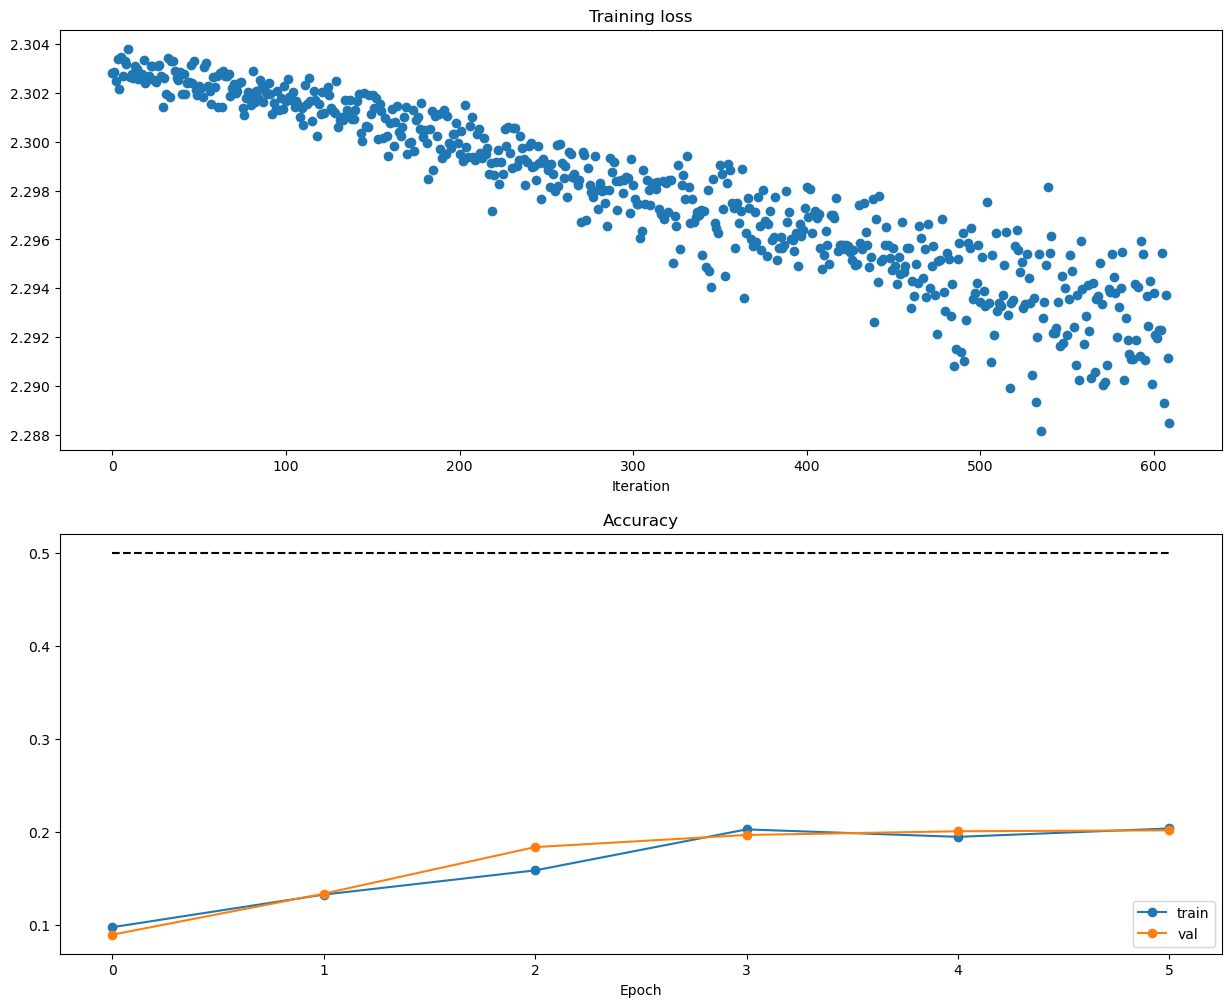

(Iteration 1 / 610) loss: 2.302397
(Epoch 0 / 5) train acc: 0.099000; val_acc: 0.087000
(Iteration 101 / 610) loss: 2.296963
(Epoch 1 / 5) train acc: 0.166000; val_acc: 0.157000
(Iteration 201 / 610) loss: 2.294206
(Epoch 2 / 5) train acc: 0.187000; val_acc: 0.177000
(Iteration 301 / 610) loss: 2.286744
(Epoch 3 / 5) train acc: 0.196000; val_acc: 0.199000
(Iteration 401 / 610) loss: 2.284941
(Epoch 4 / 5) train acc: 0.237000; val_acc: 0.212000
(Iteration 501 / 610) loss: 2.281385
(Iteration 601 / 610) loss: 2.272638
(Epoch 5 / 5) train acc: 0.241000; val_acc: 0.220000
batch_size = 400, lr = 0.000010, hidden size = 200.000000, Valid_accuracy: 0.220000


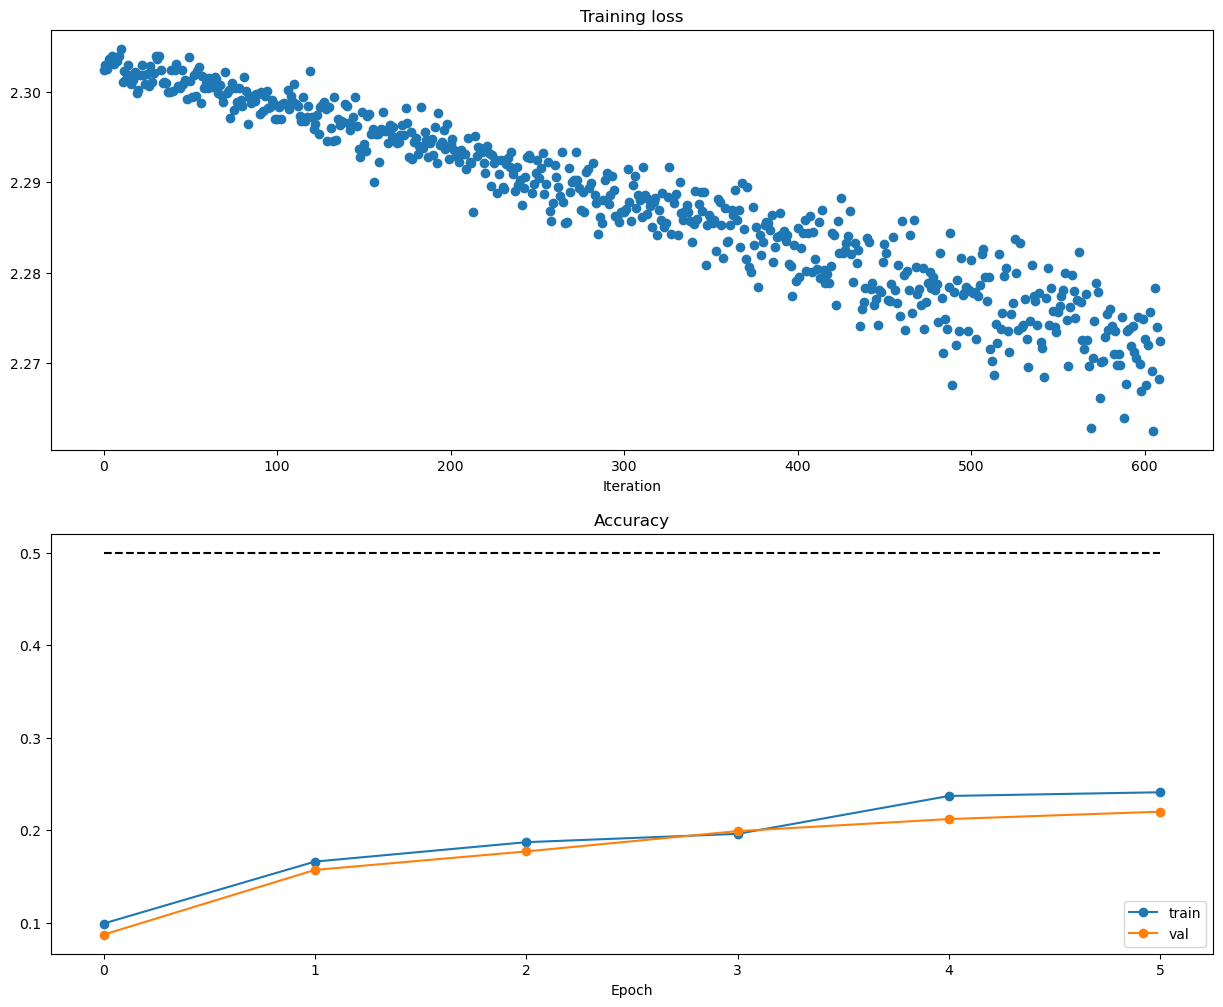

In [6]:
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data, preprocess_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver
import matplotlib.pyplot as plt
best_model = None # store the best model into this
best_acc = 0

def show_loss_acc(solver):
    plt.subplot(2, 1, 1)
    plt.title('Training loss')
    plt.plot(solver.loss_history, 'o')
    plt.xlabel('Iteration')

    plt.subplot(2, 1, 2)
    plt.title('Accuracy')
    plt.plot(solver.train_acc_history, '-o', label='train')
    plt.plot(solver.val_acc_history, '-o', label='val')
    plt.plot([0.5] * len(solver.val_acc_history), 'k--')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.gcf().set_size_inches(15, 12)
    plt.show()
    
#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_model.                                                          #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters by hand can be fun, but you might find it useful to  #
# write code to sweep through possible combinations of hyperparameters          #
# automatically like we did on thexs previous exercises.                          #
#################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = preprocess_data()
input_size = 32 * 32 * 3
num_classes = 10
data = {
    'X_train': X_train,
    'y_train': y_train,
    'X_val': X_val,
    'y_val': y_val
}

for batch_size in [200, 400]:
    for lr in [1e-3, 1e-4, 1e-5]:
        for hidden_size in [50, 100, 200]:
            model = TwoLayerNet(input_size, hidden_size, num_classes)
            solver = Solver(model, data,
                            update_rule='sgd',
                            optim_config={'learning_rate': lr, },
                            lr_decay=0.95,
                            num_epochs=5, batch_size=batch_size,
                            print_every=100)
            solver.train()
            print('batch_size = %d, lr = %f, hidden size = %f, Valid_accuracy: %f' % (
                batch_size, lr, hidden_size, solver.best_val_acc))
            if solver.best_val_acc > best_acc:
                best_acc = solver.best_val_acc
                best_model = solver
            show_loss_acc(solver)
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Test your model!
Run your best model on the validation and test sets. You should achieve above 48% accuracy on the validation set and the test set.

In [8]:
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())

AttributeError: 'Solver' object has no attribute 'loss'

In [ ]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

## Inline Question 2: 

Now that you have trained a Neural Network classifier, you may find that your testing accuracy is much lower than the training accuracy. In what ways can we decrease this gap? Select all that apply.

1. Train on a larger dataset.
2. Add more hidden units.
3. Increase the regularization strength.
4. None of the above.

$\color{blue}{\textit Your Answer:}$

$\color{blue}{\textit Your Explanation:}$

